In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import cv2

In [5]:
class GMM:
    def __init__(self, k, max_iter=100, tol=1e-4):
        self.k = k
        self.max_iter = max_iter
        self.tol = tol

    def initialize(self, X):
        self.shape = X.shape 
        self.n, self.m = self.shape 

        self.phi = np.full(shape=self.k, fill_value=1/self.k) 
        self.weights = np.full(shape=self.shape, fill_value=1/self.k)
        
        random_row = np.random.randint(low=0, high=self.n, size=self.k)
        self.mu = [X[row_index, :] for row_index in random_row] 
        self.sigma = [np.cov(X.T) for _ in range(self.k)] 

    def e_step(self, X):
        self.weights = self.predict_proba(X)
        self.phi = self.weights.mean(axis=0)

    def m_step(self, X):
        for i in range(self.k):
            weight = self.weights[:, [i]]
            total_weight = weight.sum()

            self.mu[i] = (X * weight).sum(axis=0) / total_weight
            self.sigma[i] = np.cov(X.T, aweights=(weight / total_weight).flatten(), bias=True) + np.eye(X.shape[1]) * 1e-6

    def fit(self, X):
        original_shape = X.shape
        X = X.reshape(-1, X.shape[-1])

        self.initialize(X)
        plt.figure(figsize=(16, 25))

        log_likelihood = 0
        for iteration in range(self.max_iter):
            prev_log_likelihood = log_likelihood

            clusters = self.predict(X)

            clustered_image = np.zeros_like(X)
            for i in range(self.k):
                clustered_image[clusters == i] = self.mu[i]

            plt.subplot(5, 3, iteration + 1)
            plt.imshow(clustered_image.reshape(original_shape).astype(np.uint8))
            plt.title(f'Iteration {iteration + 1}')
            plt.axis('off')

            self.e_step(X)
            self.m_step(X)

            log_likelihood = self.compute_log_likelihood(X)
            if abs(log_likelihood - prev_log_likelihood) < self.tol:
                break

        plt.tight_layout()
        plt.show()

    def predict_proba(self, X):
        likelihood = np.zeros((self.n, self.k))
        for i in range(self.k):
            distribution = multivariate_normal(mean=self.mu[i], cov=self.sigma[i])
            likelihood[:, i] = distribution.pdf(X)

        numerator = likelihood * self.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        weights = numerator / denominator
        return weights
    
    def predict(self, X):
        weights = self.predict_proba(X)
        return np.argmax(weights, axis=1)

    def compute_log_likelihood(self, X):
        likelihood = np.zeros((self.n, self.k))
        for i in range(self.k):
            distribution = multivariate_normal(mean=self.mu[i], cov=self.sigma[i])
            likelihood[:, i] = distribution.pdf(X)

        log_likelihood = np.log(likelihood.sum(axis=1)).sum()
        return log_likelihood

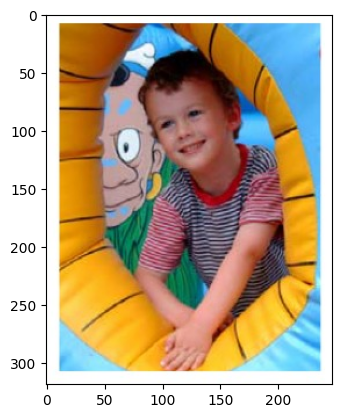

In [6]:
# Load the image
img = cv2.imread("images/image_child.jpeg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

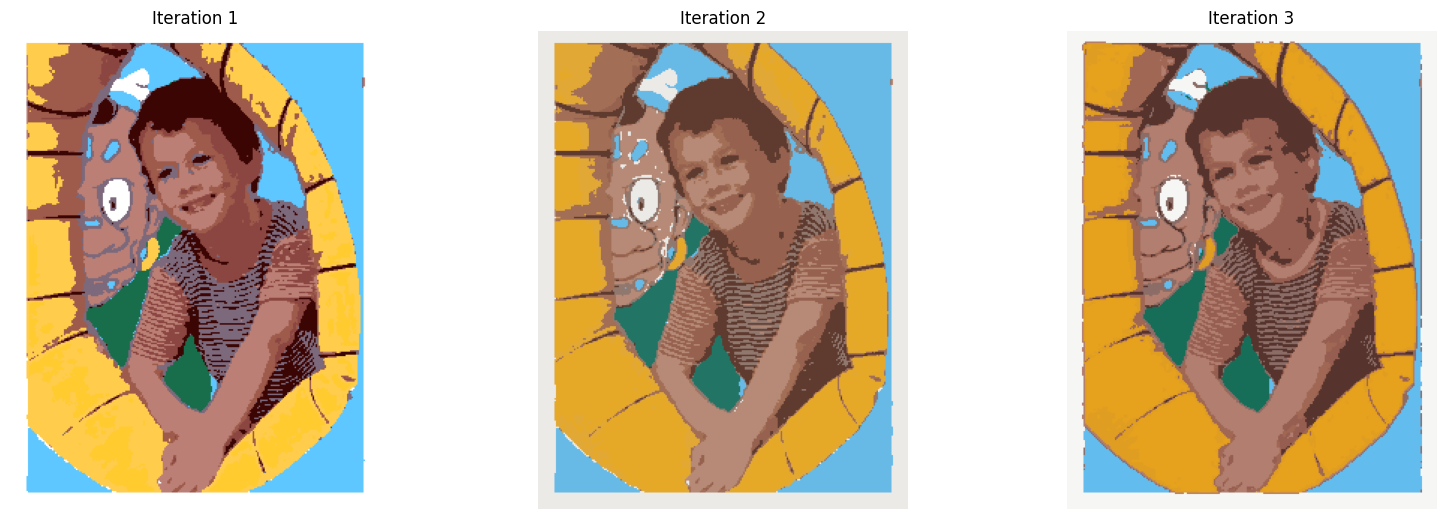

In [85]:
gmm = GMM(k=10, max_iter=3)
gmm.fit(img)